## [MAIN FILE] CUSPATIAL ANALYSIS FOR NTAD DATASET

### Simple function to measure time to find points within a polygon

In [ ]:
import geopandas as gpd
import cudf
import cuspatial
import time

# -----------------------------------------------
# 1. Load Geometries with GeoPandas (Example)
# -----------------------------------------------
gdf = gpd.read_file("data/North_American_Roads.shp")

gdf = gdf.to_crs("EPSG:4326")

# Filter out None geometries
gdf = gdf[~gdf['geometry'].isna()]

# Extract flat coordinates from LineString and MultiLineString
def extract_flat_coords(geom):
    if geom.geom_type == 'LineString':
        return list(geom.coords)
    elif geom.geom_type == 'MultiLineString':
        return [pt for line in geom.geoms for pt in line.coords]
    return []

gdf['flat_coords'] = gdf['geometry'].apply(extract_flat_coords)

# Flatten into two lists of x and y
x_coords = []
y_coords = []

for coord_list in gdf['flat_coords']:
    for x, y in coord_list:
        x_coords.append(x)
        y_coords.append(y)

# Convert to cuDF Series
x_cudf = cudf.Series(x_coords)
y_cudf = cudf.Series(y_coords)

# -----------------------------------------------
# 2. Define Bounding Box (Example Region)
# -----------------------------------------------
bbox_min_x, bbox_max_x = -140.0, -137.0  # Longitude range
bbox_min_y, bbox_max_y =  64.0,   66.0   # Latitude range

# -----------------------------------------------
# 3. Benchmark WITH Bounding Box Filtering
# -----------------------------------------------
start_time = time.time()

mask = (x_cudf >= bbox_min_x) & (x_cudf <= bbox_max_x) & \
       (y_cudf >= bbox_min_y) & (y_cudf <= bbox_max_y)

filtered_x = x_cudf[mask]
filtered_y = y_cudf[mask]

end_time = time.time()
print(f"Filtered points: {len(filtered_x)}")
print(f"Execution Time: {end_time - start_time:.4f} seconds")


Filtered points: 5590
Execution Time: 0.0090 seconds


### Querying for points/roads within a defined bounding box for NTAD Dataset

In [ ]:
import geopandas as gpd
import cudf
import cuspatial
import time

# -----------------------------------------------
# 1. Load Geometries with GeoPandas (Example)
# -----------------------------------------------
gdf = gpd.read_file("data/North_American_Roads.shp")
gdf = gdf.to_crs("EPSG:4326")
gdf = gdf[~gdf['geometry'].isna()]

def extract_flat_coords(geom):
    if geom.geom_type == 'LineString':
        return list(geom.coords)
    elif geom.geom_type == 'MultiLineString':
        return [pt for line in geom.geoms for pt in line.coords]
    return []

gdf['flat_coords'] = gdf['geometry'].apply(extract_flat_coords)

x_coords = []
y_coords = []

for coord_list in gdf['flat_coords']:
    for x, y in coord_list:
        x_coords.append(x)
        y_coords.append(y)

x_cudf = cudf.Series(x_coords)
y_cudf = cudf.Series(y_coords)

# -----------------------------------------------
# 2. Define Bounding Box (Example Region)
# -----------------------------------------------
#bbox_min_x, bbox_max_x = -140.0, -137.0 # worked for Alaska (initial example)
#bbox_min_y, bbox_max_y =  64.0,   66.0 # worked for Alaska (initial example)

# for New York City
#bbox_min_x, bbox_max_x = -74.2591, -73.7004
#bbox_min_y, bbox_max_y =  40.4774,  40.9176

# for New York State
bbox_min_x, bbox_max_x = -74.8465, -71.1859
bbox_min_y, bbox_max_y =  40.4774,  45.01585

#bbox_min_x, bbox_max_x = -79.7624, -71.8527  # Longitude bounds
#bbox_min_y, bbox_max_y =  40.4774,  45.0153  # Latitude bounds

# -----------------------------------------------
# 3. Benchmark NAÏVE (No Bounding Box)
# -----------------------------------------------
print("Starting Naïve Processing (no bounding box)...")
start_time_naive = time.time()

# Example: Simulate processing *all* points
naive_point_count = len(x_cudf)  # Count all points

end_time_naive = time.time()
print(f"Naïve Processed points: {naive_point_count}")
print(f"Naïve Execution Time: {end_time_naive - start_time_naive:.4f} seconds")

# --This will intially return almost instantly as GPU has the points on record and is not querying for anything--

# -----------------------------------------------
# 4. Benchmark WITH Bounding Box
# -----------------------------------------------
print("\nStarting Optimized Processing (bounding box filter)...")
start_time_bbox = time.time()

mask = (x_cudf >= bbox_min_x) & (x_cudf <= bbox_max_x) & \
       (y_cudf >= bbox_min_y) & (y_cudf <= bbox_max_y)

filtered_x = x_cudf[mask]
filtered_y = y_cudf[mask]

end_time_bbox = time.time()
print(f"Filtered points: {len(filtered_x)}")
print(f"Bounding Box Execution Time: {end_time_bbox - start_time_bbox:.4f} seconds")

Starting Naïve Processing (no bounding box)...
Naïve Processed points: 25224400
Naïve Execution Time: 0.0000 seconds

Starting Optimized Processing (bounding box filter)...
Filtered points: 727197
Bounding Box Execution Time: 0.0080 seconds


In [ ]:
# Actual Naive Processing by simulating a computational workload
# (e.g., distance from origin)
# -----------------------------------------------
import time
print("Starting Naïve Processing (no bounding box)...")
start_time_naive = time.time()

# Simulate a computational workload (e.g., distance from origin)
distances = (x_cudf ** 2 + y_cudf ** 2) ** 1.5

naive_result_count = len(distances)

end_time_naive = time.time()
print(f"Naïve Processed points: {naive_result_count}")
print(f"Naïve Execution Time: {end_time_naive - start_time_naive:.4f} seconds")


Starting Naïve Processing (no bounding box)...
Naïve Processed points: 25224400
Naïve Execution Time: 0.0184 seconds


##### Observe the difference between naive execution and bounding box execution times above, having a bounding box decreases the execution time significantly. Now, let's plot the records to visually represent the data and results we have queried above.

### Full DataSet Visualized with a Bounding Box of NY State

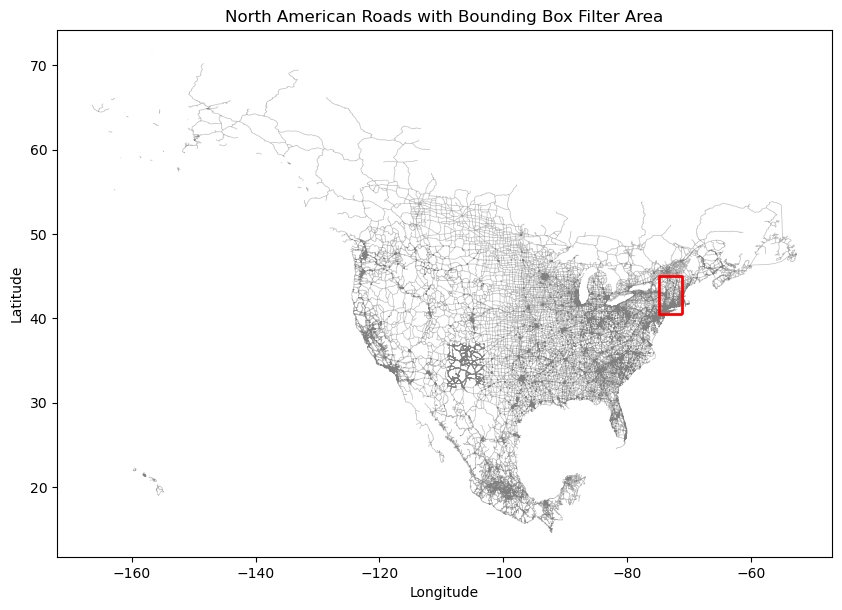

In [9]:
import matplotlib.pyplot as plt
from shapely.geometry import box

# Define Bounding Box as a Polygon (replace with your bbox values)
bbox_polygon = box(bbox_min_x, bbox_min_y, bbox_max_x, bbox_max_y)

# Convert bounding box to GeoSeries for plotting
bbox_gdf = gpd.GeoSeries([bbox_polygon], crs="EPSG:4326")

# Plot Roads and Bounding Box
fig, ax = plt.subplots(figsize=(10, 10))

# Plot all roads (transparency for visibility)
gdf.plot(ax=ax, color='gray', linewidth=0.5, alpha=0.5)

# Plot bounding box with border
bbox_gdf.boundary.plot(ax=ax, color='red', linewidth=2)

plt.title("North American Roads with Bounding Box Filter Area")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


### Closer View of the NY Bounding Box

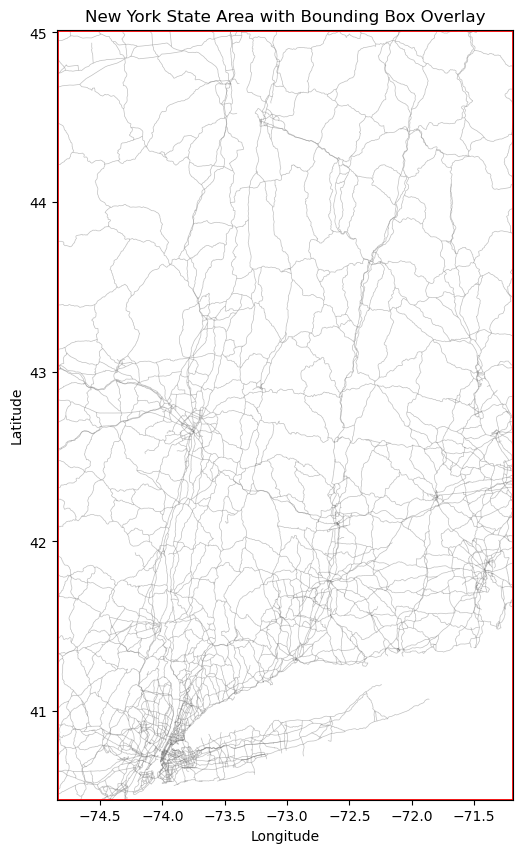

In [10]:
import matplotlib.pyplot as plt
from shapely.geometry import box

bbox_min_x, bbox_max_x = -74.8465, -71.1859
bbox_min_y, bbox_max_y =  40.4774,  45.01585

# Define New York State Bounding Box
#bbox_min_x, bbox_max_x = -79.7624, -71.8527  # Longitude bounds
#bbox_min_y, bbox_max_y =  40.4774,  45.0153  # Latitude bounds

# Create Bounding Box Polygon and GeoSeries
bbox_polygon = box(bbox_min_x, bbox_min_y, bbox_max_x, bbox_max_y)
bbox_gdf = gpd.GeoSeries([bbox_polygon], crs="EPSG:4326")

# Plot Roads and Bounding Box
fig, ax = plt.subplots(figsize=(10, 10))

# Plot all roads
gdf.plot(ax=ax, color='gray', linewidth=0.5, alpha=0.5)

# Plot bounding box
bbox_gdf.boundary.plot(ax=ax, color='red', linewidth=2)

# Zoom to NY State bounding box
ax.set_xlim(bbox_min_x, bbox_max_x)
ax.set_ylim(bbox_min_y, bbox_max_y)

plt.title("New York State Area with Bounding Box Overlay")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


### Point to Nearest Roads Distance

In [ ]:
#exploring the haversine_distance function
# -----------------------------------------------
print(help(cuspatial.haversine_distance))

Help on function haversine_distance in module cuspatial.core.spatial.distance:

haversine_distance(p1: cuspatial.core.geoseries.GeoSeries, p2: cuspatial.core.geoseries.GeoSeries)
    Compute the haversine distances in kilometers between an arbitrary
    list of lon/lat pairs
    
    Parameters
    ----------
    p1: GeoSeries
        Series of points as floats
    p2: GeoSeries
        Series of points as floats
    
    Returns
    -------
    result : cudf.Series
        The distance between pairs of points between `p1` and `p2`
    >>> import cudf
    >>> import cuspatial
    >>> a = {"latitude":[0.0,0.0,1.0,1.0],
    ...      "longitude": [0.0,1.0,0.0,1.0]}
    >>> df = cudf.DataFrame(data=a)
    
    >>> # Create cuSpatial GeoSeries from cuDF Dataframe
    >>> gs = cuspatial.GeoSeries.from_points_xy(
    ...     df[['longitude', 'latitude']].interleave_columns()
    ... )
    
    >>> # Create Comparator cuSpatial GeoSeries from a comparator point
    >>> df['compare_lat'] = 2.0 

## Finding Points within 100kms of New York City

### Usage Demo for finding nearest Roads to a point

In [ ]:
import cuspatial
import cudf
import numpy as np # For interleaving and expanding series

# --- Helper function to interleave coordinates ---
# This is needed because GeoSeries.from_points_xy in this environment
# expects a single Series of interleaved x-y coordinates.
def interleave_coords(lon_series, lat_series):
    if not isinstance(lon_series, cudf.Series) or not isinstance(lat_series, cudf.Series):
        raise TypeError("Input longitude and latitude must be cudf.Series.")
    if len(lon_series) != len(lat_series):
        raise ValueError("Longitude and Latitude series must have the same length.")
    if len(lon_series) == 0:
        # Return an empty Series with appropriate dtype if inputs are empty
        return cudf.Series([], dtype='float64') 
    
    # Ensure inputs are float64 for consistency with coordinate data
    lon_np = lon_series.astype('float64').to_numpy()
    lat_np = lat_series.astype('float64').to_numpy()
    
    interleaved_np = np.empty(len(lon_np) * 2, dtype='float64')
    interleaved_np[0::2] = lon_np
    interleaved_np[1::2] = lat_np
    return cudf.Series(interleaved_np)

# Assume x_cudf and y_cudf (for road coordinates) are already defined as cudf.Series
x_cudf = cudf.Series([-73.985130, -73.990000, -74.000000, -73.900000, -73.935242], dtype='float64')
y_cudf = cudf.Series([40.758896, 40.750000, 40.740000, 40.700000, 40.730610], dtype='float64')

# Reference coordinates (single point)
# Ensure they are float type
orig_ref_lon_series = cudf.Series([-73.935242], dtype='float64')
orig_ref_lat_series = cudf.Series([40.730610], dtype='float64')

# Road coordinates
road_lon = x_cudf
road_lat = y_cudf

# Number of road points
num_road_points = len(road_lon)

if num_road_points == 0:
    print("Road coordinates are empty. No distances to compute.")
    filtered_x = cudf.Series([], dtype=road_lon.dtype)
else:
    # Expand the single reference point to match the number of road points
    expanded_ref_lon = cudf.Series(np.full(num_road_points, orig_ref_lon_series.iloc[0]), dtype='float64')
    expanded_ref_lat = cudf.Series(np.full(num_road_points, orig_ref_lat_series.iloc[0]), dtype='float64')

    # Interleave coordinates for GeoSeries creation
    interleaved_expanded_ref_coords = interleave_coords(expanded_ref_lon, expanded_ref_lat)
    interleaved_road_coords = interleave_coords(road_lon, road_lat)

    # Create GeoSeries objects
    # cuspatial.GeoSeries.from_points_xy in this environment expects interleaved coordinates
    p1_ref_expanded_gs = cuspatial.GeoSeries.from_points_xy(interleaved_expanded_ref_coords)
    p2_road_gs = cuspatial.GeoSeries.from_points_xy(interleaved_road_coords)

    # Compute distances. This function in this environment returns distances in KILOMETERS.
    distances_km = cuspatial.haversine_distance(
        p1_ref_expanded_gs,
        p2_road_gs
    )

    # Filter points within 10 km
    # Adjust threshold to 10.0 for kilometers
    within_10km_mask = distances_km <= 10.0

    filtered_x = road_lon[within_10km_mask]
    filtered_y = road_lat[within_10km_mask]

print(f"Points within 10km: {len(filtered_x)}")
if len(filtered_x) > 0:
    print("Sample of filtered road coordinates (first 5 if available):")
    # Displaying the filtered coordinates in a DataFrame
    filtered_points_df = cudf.DataFrame({
        'longitude': filtered_x,
        'latitude': filtered_y,
        'distance_km': distances_km[within_10km_mask] # Show distances for context
    })
    print(filtered_points_df.head())

Points within 10km: 5
Sample of filtered road coordinates (first 5 if available):
   longitude   latitude   distance_km
0 -73.985130  40.758896  5.249371e+00
1 -73.990000  40.750000  5.092305e+00
2 -74.000000  40.740000  5.555254e+00
3 -73.900000  40.700000  4.517450e+00
4 -73.935242  40.730610  4.710382e-13


### Finding Points within 100kms of New York City

In [24]:
import cuspatial
import cudf
import numpy as np

def interleave_coords(lon_series, lat_series):
    lon_np = lon_series.astype('float64').to_numpy()
    lat_np = lat_series.astype('float64').to_numpy()
    interleaved_np = np.empty(len(lon_np) * 2, dtype='float64')
    interleaved_np[0::2] = lon_np
    interleaved_np[1::2] = lat_np
    return cudf.Series(interleaved_np)

gdf = gpd.read_file("data/North_American_Roads.shp")
gdf = gdf.to_crs("EPSG:4326")
gdf = gdf[~gdf['geometry'].isna()]

def extract_flat_coords(geom):
    if geom.geom_type == 'LineString':
        return list(geom.coords)
    elif geom.geom_type == 'MultiLineString':
        return [pt for line in geom.geoms for pt in line.coords]
    return []

gdf['flat_coords'] = gdf['geometry'].apply(extract_flat_coords)

x_coords = []
y_coords = []

for coord_list in gdf['flat_coords']:
    for x, y in coord_list:
        x_coords.append(x)
        y_coords.append(y)

x_cudf = cudf.Series(x_coords, dtype='float64')
y_cudf = cudf.Series(y_coords, dtype='float64')

ref_lon_series = cudf.Series([-73.935242], dtype='float64')
ref_lat_series = cudf.Series([40.730610], dtype='float64')

num_points = len(x_cudf)

expanded_ref_lon = cudf.Series(np.full(num_points, ref_lon_series.iloc[0]), dtype='float64')
expanded_ref_lat = cudf.Series(np.full(num_points, ref_lat_series.iloc[0]), dtype='float64')

interleaved_ref_coords = interleave_coords(expanded_ref_lon, expanded_ref_lat)
interleaved_road_coords = interleave_coords(x_cudf, y_cudf)

ref_points = cuspatial.GeoSeries.from_points_xy(interleaved_ref_coords)
road_points = cuspatial.GeoSeries.from_points_xy(interleaved_road_coords)

distances_km = cuspatial.haversine_distance(ref_points, road_points)

within_100km = distances_km <= 100.0

filtered_x = x_cudf[within_100km]
filtered_y = y_cudf[within_100km]

print(f"Points within 100km: {len(filtered_x)}")

if len(filtered_x) > 0:
    filtered_df = cudf.DataFrame({
        'longitude': filtered_x,
        'latitude': filtered_y,
        'distance_km': distances_km[within_100km]
    })
    print(filtered_df.head())


Points within 100km: 254682
          longitude   latitude  distance_km
19929301 -74.959616  40.924210    88.837175
19929302 -74.959481  40.924175    88.825234
19929303 -74.959240  40.924120    88.804114
19929304 -74.958901  40.924054    88.774705
19929305 -74.958626  40.924007    88.751020


### Highlighting the area specified in the whole dataset

/home/saketh/miniconda3/envs/cuspatial_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


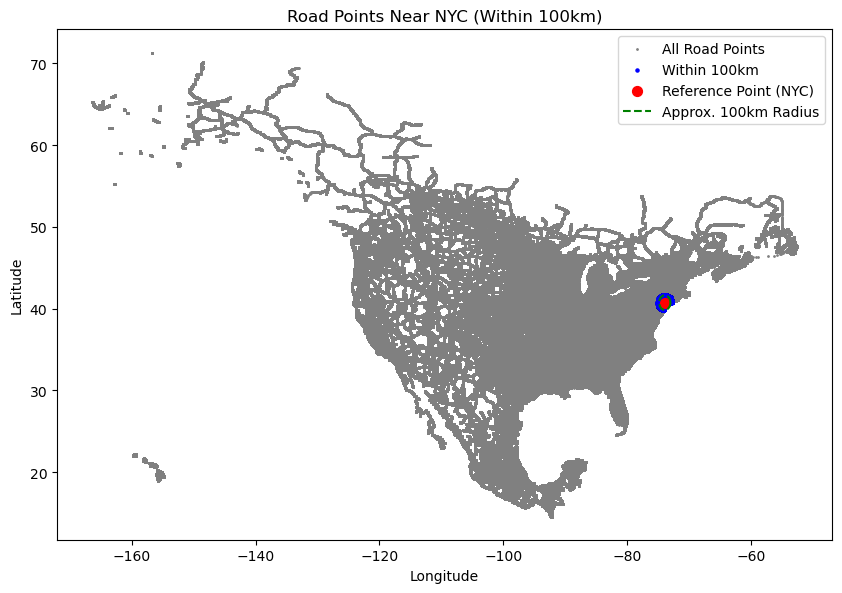

In [25]:
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.geometry import Polygon
import geopandas as gpd

# Convert all road points to GeoDataFrame for plotting
all_road_points = gpd.GeoDataFrame(geometry=gpd.points_from_xy(x_coords, y_coords), crs="EPSG:4326")
filtered_points = gpd.GeoDataFrame(geometry=gpd.points_from_xy(filtered_x.to_pandas(), filtered_y.to_pandas()), crs="EPSG:4326")

# Reference point as GeoDataFrame
ref_point_geom = Point(-73.935242, 40.730610)
ref_gdf = gpd.GeoDataFrame(geometry=[ref_point_geom], crs="EPSG:4326")

# Optional Circle (approximation using buffer with degree units)
radius_degrees = 100 / 111  # 1 degree ≈ 111 km
circle_geom = ref_point_geom.buffer(radius_degrees)
circle_gdf = gpd.GeoDataFrame(geometry=[circle_geom], crs="EPSG:4326")

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

all_road_points.plot(ax=ax, color='gray', markersize=1, label='All Road Points')
filtered_points.plot(ax=ax, color='blue', markersize=5, label='Within 100km')
ref_gdf.plot(ax=ax, color='red', markersize=50, label='Reference Point (NYC)')
circle_gdf.boundary.plot(ax=ax, color='green', linestyle='--', label='Approx. 100km Radius')

plt.legend()
plt.title("Road Points Near NYC (Within 100km)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


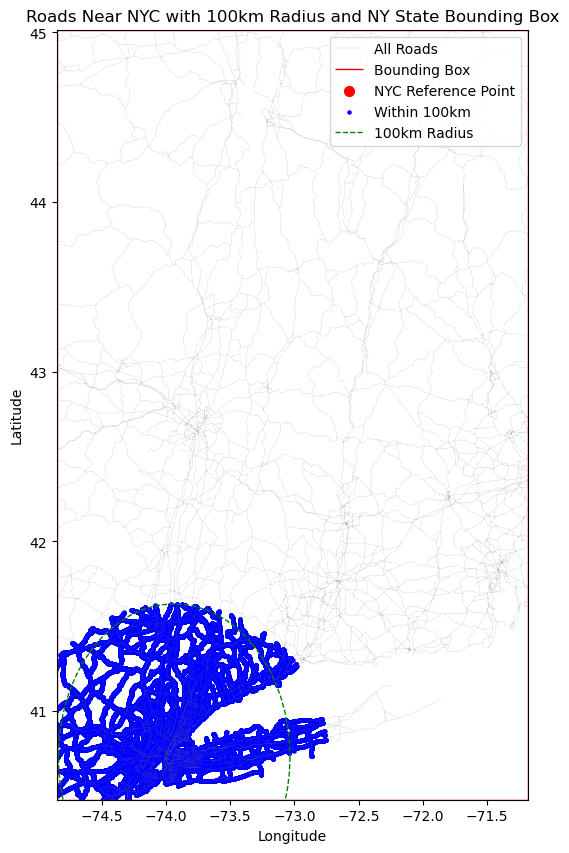

In [26]:
import matplotlib.pyplot as plt
from shapely.geometry import Point, box
import geopandas as gpd

# Bounding Box Coordinates (NY State)
bbox_min_x, bbox_max_x = -74.8465, -71.1859
bbox_min_y, bbox_max_y =  40.4774,  45.01585

# Create Bounding Box Polygon and GeoSeries
bbox_polygon = box(bbox_min_x, bbox_min_y, bbox_max_x, bbox_max_y)
bbox_gdf = gpd.GeoSeries([bbox_polygon], crs="EPSG:4326")

# Convert road points to GeoDataFrame
all_road_points = gpd.GeoDataFrame(geometry=gpd.points_from_xy(x_coords, y_coords), crs="EPSG:4326")
filtered_points = gpd.GeoDataFrame(geometry=gpd.points_from_xy(filtered_x.to_pandas(), filtered_y.to_pandas()), crs="EPSG:4326")

# Reference point as GeoDataFrame
ref_point_geom = Point(-73.935242, 40.730610)
ref_gdf = gpd.GeoDataFrame(geometry=[ref_point_geom], crs="EPSG:4326")

# Optional 100 km Circle
radius_degrees = 100 / 111
circle_geom = ref_point_geom.buffer(radius_degrees)
circle_gdf = gpd.GeoDataFrame(geometry=[circle_geom], crs="EPSG:4326")

# Plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot all roads with thin gray lines
gdf.plot(ax=ax, color='gray', linewidth=0.2, alpha=0.5, label='All Roads')

# Plot bounding box
bbox_gdf.boundary.plot(ax=ax, color='red', linewidth=1, label='Bounding Box')

# Plot reference point
ref_gdf.plot(ax=ax, color='red', markersize=50, label='NYC Reference Point')

# Plot roads within 100km
filtered_points.plot(ax=ax, color='blue', markersize=5, label='Within 100km')

# Plot 100 km boundary
circle_gdf.boundary.plot(ax=ax, color='green', linestyle='--', linewidth=1, label='100km Radius')

# Zoom to NY State bounding box
ax.set_xlim(bbox_min_x, bbox_max_x)
ax.set_ylim(bbox_min_y, bbox_max_y)

plt.title("Roads Near NYC with 100km Radius and NY State Bounding Box")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()


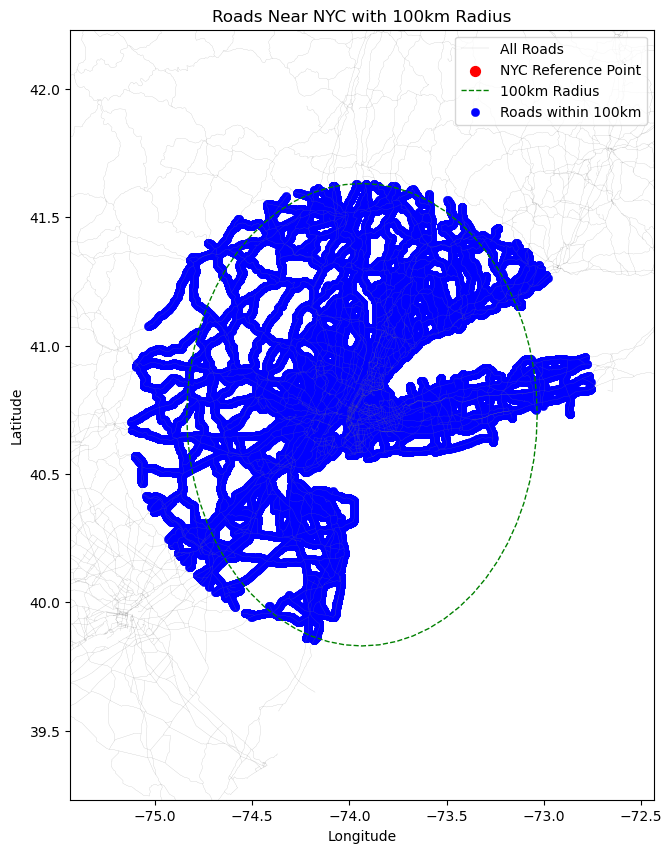

In [27]:
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd

# NYC Reference Point
ref_lon = -73.935242
ref_lat = 40.730610
ref_point_geom = Point(ref_lon, ref_lat)
ref_gdf = gpd.GeoDataFrame(geometry=[ref_point_geom], crs="EPSG:4326")

# 100 km Circle
radius_degrees = 100 / 111  # approx conversion from km to degrees
circle_geom = ref_point_geom.buffer(radius_degrees)
circle_gdf = gpd.GeoDataFrame(geometry=[circle_geom], crs="EPSG:4326")

# Convert filtered coordinates to LineString (optional, if available) or as points
filtered_line_geoms = gpd.GeoDataFrame(geometry=gpd.points_from_xy(
    filtered_x.to_pandas(), filtered_y.to_pandas()), crs="EPSG:4326")

# Plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot all roads with thin gray lines
gdf.plot(ax=ax, color='gray', linewidth=0.2, alpha=0.5, label='All Roads')

# Plot reference point
ref_gdf.plot(ax=ax, color='red', markersize=50, label='NYC Reference Point')

# Plot 100 km radius
circle_gdf.boundary.plot(ax=ax, color='green', linestyle='--', linewidth=1, label='100km Radius')

# Plot nearby roads as slim blue lines or dots
filtered_line_geoms.plot(ax=ax, color='blue', linewidth=0.3, label='Roads within 100km')

# Adjust viewport to focus on the radius area
margin_deg = 1.5  # degrees margin around NYC
ax.set_xlim(ref_lon - margin_deg, ref_lon + margin_deg)
ax.set_ylim(ref_lat - margin_deg, ref_lat + margin_deg)

plt.title("Roads Near NYC with 100km Radius")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()


### Plot Showing Roads within a Radius of 100km from New York City

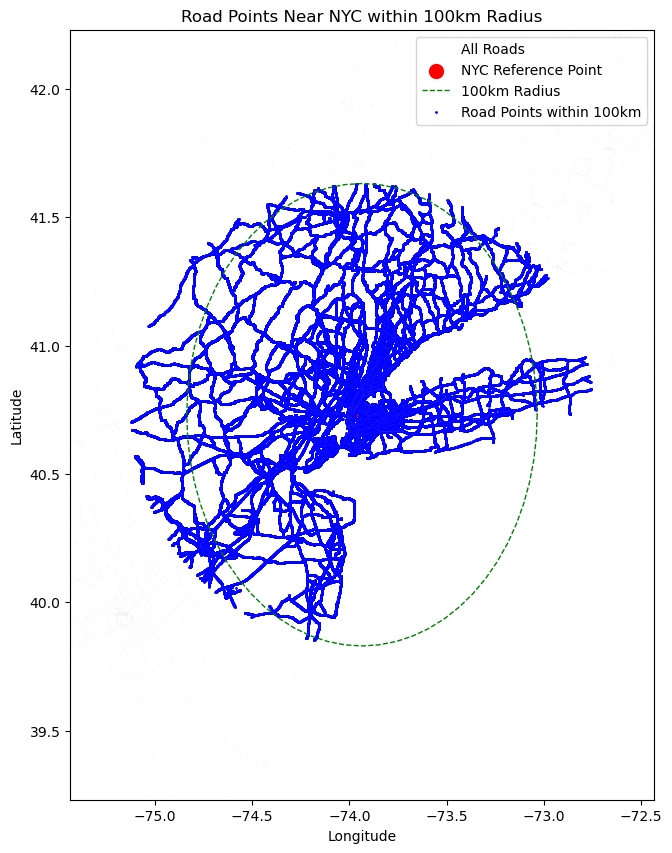

In [29]:
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd

# NYC Reference Point
ref_lon = -73.935242
ref_lat = 40.730610
ref_point_geom = Point(ref_lon, ref_lat)
ref_gdf = gpd.GeoDataFrame(geometry=[ref_point_geom], crs="EPSG:4326")

# 100 km Circle
radius_degrees = 100 / 111
circle_geom = ref_point_geom.buffer(radius_degrees)
circle_gdf = gpd.GeoDataFrame(geometry=[circle_geom], crs="EPSG:4326")

# Convert filtered coordinates to points
filtered_points = gpd.GeoDataFrame(geometry=gpd.points_from_xy(
    filtered_x.to_pandas(), filtered_y.to_pandas()), crs="EPSG:4326")

fig, ax = plt.subplots(figsize=(10, 10))

# Plot all roads in very light gray lines
gdf.plot(ax=ax, color='lightgray', linewidth=0.1, alpha=0.3, label='All Roads')

# Plot reference point
ref_gdf.plot(ax=ax, color='red', markersize=100, label='NYC Reference Point')

# Plot 100 km radius
circle_gdf.boundary.plot(ax=ax, color='green', linestyle='--', linewidth=1, label='100km Radius')

# Plot roads within 100km as small scatter points (dots)
filtered_points.plot(ax=ax, color='blue', markersize=1, label='Road Points within 100km')

# Adjust viewport to focus on the area surrounding NYC
margin_deg = 1.5
ax.set_xlim(ref_lon - margin_deg, ref_lon + margin_deg)
ax.set_ylim(ref_lat - margin_deg, ref_lat + margin_deg)

plt.title("Road Points Near NYC within 100km Radius")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()
